## Feature compression

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from sklearn.decomposition import PCA, KernelPCA
from scipy.fftpack import dct, idct
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

In [2]:
def features_scaler(features):
    '''Scale the features by min-max scaler, to ensure that the features selected by Lasso are not biased by the scale of the features'''
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_features = scaler.fit_transform(features)
    return pd.DataFrame(scaled_features)

def pca_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using PCA'''
    features = features_scaler(embeddings.T)
    pca = PCA(num_pca_components)
    embed_trans = pca.fit_transform(features).T
    return embed_trans

def kernel_pca_rbf_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using kernel PCA'''
    features = features_scaler(embeddings.T)
    kpca_rbf = KernelPCA(kernel="rbf", gamma=None, n_components=num_pca_components, n_jobs=16)
    kpca_rbf_features = kpca_rbf.fit_transform(features)
    return kpca_rbf_features.T

def kernel_pca_sigmoid_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using kernel PCA'''
    features = features_scaler(embeddings.T)
    kpca_sigmoid = KernelPCA(kernel="sigmoid", gamma=None, n_components=num_pca_components, n_jobs=16)
    kpca_sigmoid_features = kpca_sigmoid.fit_transform(features)
    return kpca_sigmoid_features.T

def tSNE_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using tSNE'''
    features = features_scaler(embeddings.T)
    tSNE_model = TSNE(n_components=num_pca_components, n_jobs=16, metric='cosine')
    tSNE_features = tSNE_model.fit_transform(features)
    return tSNE_features.T

def iDCTquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    return trans.T

def quant2D(emb, n=32, m=128):
    dct = iDCTquant(emb[1:len(emb)-1],n)
    ddct = iDCTquant(dct.T,m).T
    ddct = ddct.reshape(n*m) # turn a 2D array into a 1D vector
    return ddct
    

In [3]:
def load_per_tok_embeds(dir_path, compression_method, rep_layer=30):
    embeddings = {}
    count=0
    for file in os.listdir(dir_path):
        if file.endswith('.pt'):
            file_path = os.path.join(dir_path, file)
            label = file.split('.pt')[0]

            if compression_method == 'mean':
                embed = np.array(torch.load(file_path)['mean_representations'][rep_layer])
                embeddings[label] = embed

            elif compression_method == 'bos':
                embed = np.array(torch.load(file_path)['bos_representations'][rep_layer])
                embeddings[label] = embed

            elif compression_method == 'maxPool':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = embed.max(axis=0)
                embeddings[label] = embed_trans

            elif compression_method == 'pca1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans[0]

            elif compression_method == 'pca2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans[1]

            elif compression_method == 'pca1-2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans.reshape(-1)

            elif compression_method == 'rbf1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_rbf_transformation(embed)
                embeddings[label] = embed_trans[0]

            elif compression_method == 'rbf2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_rbf_transformation(embed)
                embeddings[label] = embed_trans[1]

            elif compression_method == 'sigmoid1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_sigmoid_transformation(embed)
                embeddings[label] = embed_trans[0]

            elif compression_method == 'sigmoid2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_sigmoid_transformation(embed)
                embeddings[label] = embed_trans[1]

            elif compression_method == 'iDCT':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embeddings[label] = quant2D(embed)
                
        
            else:
                raise ValueError('Invalid compression method')
                print('Valid compression methods are: mean, bos, max_pool, pca1, pca2, pca1-2, rbf1, rbf2, sigmoid1, sigmoid2')
          

        count+=1
        if count % 1000 == 0:
            print(f'{count} files compressed')

    return embeddings

In [5]:
dir_path = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
for i in ['mean', 'bos', 'max_pool', 'pca1', 'pca2', 'pca1-2', 'iDCT', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
        pickle.dump(embed, f)

Compressing embeddings using iDCT


1000 files compressed
2000 files compressed
3000 files compressed
4000 files compressed
5000 files compressed


In [12]:
def run_regression(features, target, target_name):
    '''this version computes y_pred for train and test sets'''
    # Initialize lists for storing results
    folds, num_zero_coefs = [], []
    r2s_train,  maes_train, rmses_train = [], [], []
    r2s_test, maes_test, rmses_test = [], [], []
    rhos_train, rhos_test = [], []

    # Define the KFold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Loop over the KFold splits
    for kfold, (train_index, test_index) in enumerate(kf.split(features)):
        # Split the data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Define and train the regression model
        model = Lasso(alpha=0.0005, random_state=42, max_iter=10000, tol=0.001)
        model.fit(X_train, y_train)

        # get the number of non-zero coefficients
        coeficients = model.coef_
        num_zero_coef = np.sum(coeficients != 0)

        # Make predictions
        y_pred_train = pd.DataFrame(model.predict(X_train))
        y_pred_test = pd.DataFrame(model.predict(X_test))

        # Evaluate the model
        r2_train = metrics.r2_score(y_train, y_pred_train)
        mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
        mse_train = metrics.mean_squared_error(y_train, y_pred_train)
        rmse_train = np.sqrt(mse_train)
        rho_train, p_value_train = spearmanr(y_train, y_pred_train)

        r2_test = metrics.r2_score(y_test, y_pred_test)
        mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred_test)
        rmse_test = np.sqrt(mse_test)
        rho_test, p_value_test = spearmanr(y_test, y_pred_test)
        
        

        # Append results
        r2s_train.append(r2_train)
        maes_train.append(mae_train)
        rmses_train.append(rmse_train)
        rhos_train.append(rho_train)

        r2s_test.append(r2_test)
        maes_test.append(mae_test)
        rmses_test.append(rmse_test)
        rhos_test.append(rho_test)

        folds.append(kfold + 1)
        num_zero_coefs.append(num_zero_coef)


        # Return the collected results
        #print(f"Results for {target_name},  fold {kfold}, r2_test: {r2_test}, rho: {rho_test}, Num coefs: {num_zero_coef}")
    return r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_zero_coefs


def save_results(layer, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_zero_coefs):
    # Create dictionary for results
    res_dict = {
        "Layer": [layer] * 10,
        "Model": ['Lasso'] * 10,
        "Fold": folds,
        "R2_score_train": r2s_train,
        "MAE_score_train": maes_train,
        "RMSE_score_train": rmses_train,
        "R2_score_test": r2s_test,
        "MAE_score_test": maes_test,
        "RMSE_score_test": rmses_test,
        "rho_score_train": rhos_train,
        "rho_score_test": rhos_test,

        "nun_zero_coefs": num_zero_coefs
    }

    # Convert results to DataFrame
    results = pd.DataFrame(res_dict).reset_index(drop=True)
    return results



def run_regression_on_compressed_files(target_name, path_compressed_embeds, path_meta_data, layer=30):
    '''Run regression on compressed embeddings'''
    meta_data = pd.read_csv(path_meta_data)

    results = pd.DataFrame()
    for file in os.listdir(path):
        if file.endswith('.pkl'):
            method = file.split('_')[-1].split('.')[0]
            print('Results for method:', method)
            file_path = os.path.join(path_compressed_embeds, file)
            embed = pd.read_pickle(file_path)
            embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
            embed_df.rename(columns={'index': 'ID'}, inplace=True)

            data = meta_data.merge(embed_df, how='inner', left_on='ID', right_on='ID')
            target = data[target_name]
            features = data.iloc[:, meta_data.shape[1]:]
            features = features_scaler(features)

            # run regression
            r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_zero_coefs = run_regression(features, target, target_name)
            res = save_results(layer, r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_zero_coefs)
            res['Compression_methd'] = method
            results = pd.concat([results, res], axis=0)

    return results

In [18]:
# df = pd.read_csv('data/sumo1_human_metadata.csv', index_col=0)#[['ID', 'Mutation', 'MIC_Score', 'sequences']]
# df.rename(columns={'screen.score':'Target'}, inplace=True)
# df.to_csv('data/sumo1_human_metadata_v02.csv', index=False)

## Testing Feature compression on DMS datasets
### BLAT_ECOLX_Ostermeier2014

In [10]:
target_name = 'fitness'
path_compressed_embed = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed'
path_meta_data = 'data/BLAT_ECOLX_Ostermeier2014_metadata.csv'
results = run_regression_on_compressed_files(target_name, path_compressed_embed, path_meta_data, layer=30)
results

,Layer,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
8,30,Lasso,9,0.446640,0.280454,0.337980,0.401715,0.286031,0.347643,0.705047,0.658699,171,bos
6,30,Lasso,7,0.440423,0.281606,0.339684,0.453584,0.278561,0.334585,0.699525,0.705247,178,bos
5,30,Lasso,6,0.449256,0.279868,0.337514,0.402724,0.285618,0.345405,0.703652,0.684230,170,bos
4,30,Lasso,5,0.445101,0.279903,0.338094,0.416969,0.292914,0.347389,0.700850,0.694817,161,bos
3,30,Lasso,4,0.443989,0.280994,0.338368,0.443467,0.279296,0.340263,0.703353,0.690204,175,bos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,30,Lasso,7,0.523157,0.255115,0.313569,0.484725,0.266248,0.324911,0.763340,0.743341,194,pca2
7,30,Lasso,8,0.522370,0.255165,0.312608,0.485868,0.271596,0.336223,0.762410,0.756984,193,pca2
9,30,Lasso,10,0.519355,0.256807,0.315540,0.496443,0.256621,0.314810,0.760174,0.746960,183,pca2
5,30,Lasso,6,0.524004,0.255770,0.313775,0.484719,0.258894,0.320821,0.762126,0.760129,193,pca2


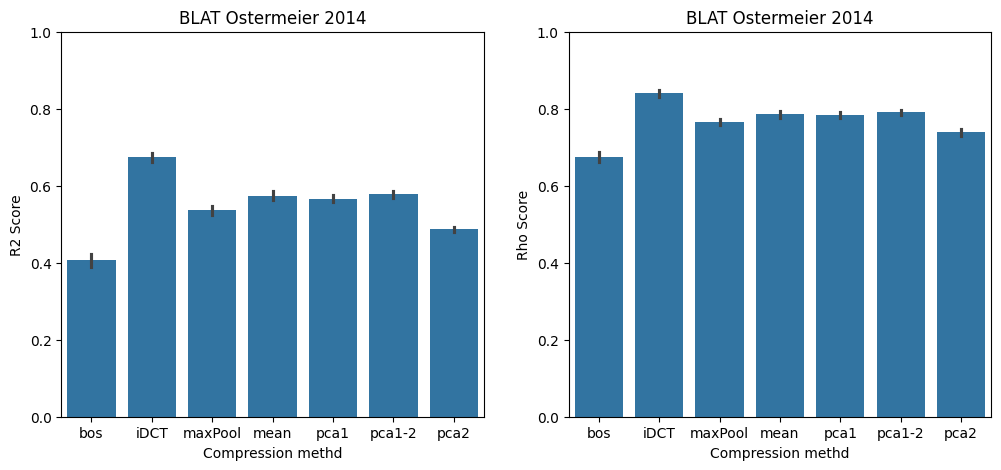

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
results.sort_values('Compression_methd', inplace=True)
sns.barplot(data=results, x='Compression_methd', y='R2_score_test', ax=ax[0])
ax[0].set_title('BLAT Ostermeier 2014')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('R2 Score')
ax[0].set_xlabel('Compression methd')

sns.barplot(data=results, x='Compression_methd', y='rho_score_test', ax=ax[1])
ax[1].set_title('BLAT Ostermeier 2014')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Rho Score')
ax[1].set_xlabel('Compression methd')
plt.show()

## Classification

## cov2_ace2

In [12]:
meta_data = pd.read_csv('data/cov2_ace2_bind_all_metadata.csv', index_col=0)
n= 1350
meta_data = meta_data.groupby('log_fitness', group_keys=False).apply(lambda x: x.sample(n) if len(x) > n else pd.DataFrame())
meta_data['log_fitness'].value_counts()

log_fitness
0    1350
1    1350
Name: count, dtype: int64

In [13]:
def run_Log_regression(features, target, target_name, num_classes):
    # Initialize lists for storing results
    folds = []
    accuracies_train, recalls_train, precisions_train, f1_scores_train = [], [], [], []
    accuracies_test, recalls_test, precisions_test, f1_scores_test = [], [], [], []
    coefs = []

    # Define the KFold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Loop over the KFold splits
    for kfold, (train_index, test_index) in enumerate(kf.split(features)):
        # Split the data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Define and train the regression model
        model = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = pd.DataFrame(model.predict(X_train))
        y_pred_test = pd.DataFrame(model.predict(X_test))

        # get the number of non-zero coefficients
        coefficients = model.coef_
        coefs.append(np.sum(coefficients != 0))

        # Evaluate the model on overall metrics
        accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
        recall_train = metrics.recall_score(y_train, y_pred_train)
        precision_train = metrics.precision_score(y_train, y_pred_train)
        f1_score_train = metrics.f1_score(y_train, y_pred_train)

        accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
        recall_test = metrics.recall_score(y_test, y_pred_test)
        precision_test = metrics.precision_score(y_test, y_pred_test)
        f1_score_test = metrics.f1_score(y_test, y_pred_test)

        print(f"Results for {target_name},  fold {kfold}, accuracy_test: {accuracy_test}, recall_test: {recall_test}, precision_test: {precision_test}, f1_score_test: {f1_score_test}, Num coefs: {coefs}")
       
        # Append results
        accuracies_train.append(accuracy_train)
        recalls_train.append(recall_train)
        precisions_train.append(precision_train)
        f1_scores_train.append(f1_score_train)

        accuracies_test.append(accuracy_test)
        recalls_test.append(recall_test)
        precisions_test.append(precision_test)
        f1_scores_test.append(f1_score_test)


        folds.append(kfold + 1)
    # Return the collected results
    return accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs


def save_results(layer, accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs):
    # Create dictionary for results
    res_dict = {
        "Layer": [layer] * 10,
        "Model": ['LogR'] * 10,
        "Fold": folds,
        "Accuracy_train": accuracies_train,
        "Recall_train": recalls_train,
        "Precision_train": precisions_train,
        "F1_score_train": f1_scores_train,
        "Accuracy_test": accuracies_test,
        "Recall_test": recalls_test,
        "Precision_test": precisions_test,
        "F1_score_test": f1_scores_test,
        "num_non_zero_coefs": coefs
    }

    # Convert results to DataFrame
    results = pd.DataFrame(res_dict).reset_index(drop=True)
    return results


In [14]:
path = 'embeddings/cov2_ace2_esm2_150M_compressed'
layer = 30
target_name = 'log_fitness'
results = pd.DataFrame()
for file in os.listdir(path):
    if file.endswith('.pkl') and file not in ['embed_layer_30_tSNE.pkl']:
        method = file.split('_')[-1].split('.')[0]
        print('Results for method:', method)
        file_path = os.path.join(path, file)
        embeds = pd.read_pickle(file_path)
        data = meta_data.merge(embeds, how='inner', left_on='ID', right_on='ID')
        target = data[target_name]
        features = data.iloc[:, meta_data.shape[1]:]
        features = features_scaler(features)
     
        # run classification
        accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs = run_Log_regression(features, target, target_name, 2)
        res = save_results(layer, accuracies_train, recalls_train, precisions_train, f1_scores_train, accuracies_test, recalls_test, precisions_test, f1_scores_test, folds, coefs)
        res['Compression_methd'] = method
        results = pd.concat([results, res], axis=0)

Results for method: sigmoid
Results for log_fitness,  fold 0, accuracy_test: 0.8592592592592593, recall_test: 0.9112903225806451, precision_test: 0.8071428571428572, f1_score_test: 0.8560606060606061, Num coefs: [137]
Results for log_fitness,  fold 1, accuracy_test: 0.8740740740740741, recall_test: 0.8823529411764706, precision_test: 0.8695652173913043, f1_score_test: 0.8759124087591241, Num coefs: [137, 132]
Results for log_fitness,  fold 2, accuracy_test: 0.9074074074074074, recall_test: 0.8943661971830986, precision_test: 0.927007299270073, f1_score_test: 0.910394265232975, Num coefs: [137, 132, 151]
Results for log_fitness,  fold 3, accuracy_test: 0.9185185185185185, recall_test: 0.9253731343283582, precision_test: 0.9117647058823529, f1_score_test: 0.9185185185185185, Num coefs: [137, 132, 151, 141]
Results for log_fitness,  fold 4, accuracy_test: 0.9, recall_test: 0.8686131386861314, precision_test: 0.9296875, f1_score_test: 0.89811320754717, Num coefs: [137, 132, 151, 141, 143]


In [19]:
#results.to_csv('results/classification/compression/cov2_ace2_esm2_150M_layer_30_compressed.csv', index=False)
results = pd.read_csv('results/classification/compression/cov2_ace2_esm2_150M_layer_30_compressed.csv')
results.sort_values('Compression_methd', inplace=True)
results

,Layer,Model,Fold,Accuracy_train,Recall_train,Precision_train,F1_score_train,Accuracy_test,Recall_test,Precision_test,F1_score_test,num_non_zero_coefs,Compression_methd
0,30,LogR,10,0.899588,0.904921,0.893004,0.898923,0.892593,0.900662,0.906667,0.903654,152,bos
1,30,LogR,1,0.907407,0.916803,0.901363,0.909017,0.851852,0.870968,0.818182,0.843750,158,bos
2,30,LogR,2,0.905761,0.915980,0.897498,0.906645,0.862963,0.845588,0.877863,0.861423,160,bos
3,30,LogR,3,0.903704,0.913079,0.895292,0.904098,0.866667,0.866197,0.878571,0.872340,151,bos
4,30,LogR,4,0.899588,0.912829,0.889423,0.900974,0.885185,0.858209,0.905512,0.881226,158,bos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,30,LogR,10,0.920988,0.929108,0.912367,0.920661,0.907407,0.900662,0.931507,0.915825,149,sigmoid
65,30,LogR,7,0.924691,0.933443,0.917609,0.925458,0.885185,0.894737,0.875000,0.884758,148,sigmoid
66,30,LogR,8,0.927160,0.936170,0.920354,0.928195,0.892593,0.898438,0.877863,0.888031,140,sigmoid
67,30,LogR,9,0.921399,0.929038,0.916331,0.922641,0.900000,0.935484,0.859259,0.895753,144,sigmoid


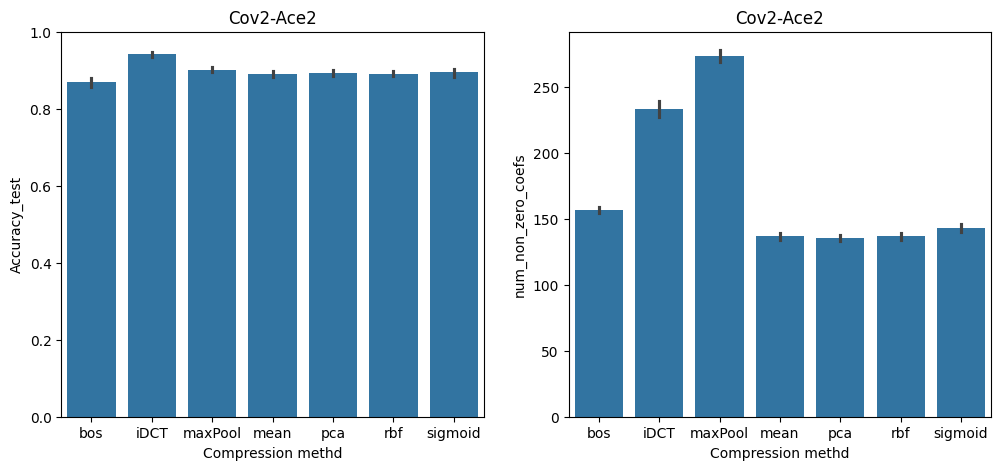

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=results, x='Compression_methd', y='Accuracy_test', ax=ax[0])
ax[0].set_title('Cov2-Ace2')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Accuracy_test')
ax[0].set_xlabel('Compression methd')

sns.barplot(data=results, x='Compression_methd', y='num_non_zero_coefs', ax=ax[1])
ax[1].set_title('Cov2-Ace2')
#ax[1].set_ylim(0, 1)
ax[1].set_ylabel('num_non_zero_coefs')
ax[1].set_xlabel('Compression methd')
plt.show()